# Import Modules

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, Model
from keras_tuner.tuners import BayesianOptimization
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

# Data Preprocessing

## Parsing data functions - PSSM, DSSP, sequences

Utility functions to parse and preprocess data. DSSP labels, PSSM and amino acid sequence features.

Preprocessing steps:
- Parse PSSM, DSSP and sequence files.
- Concatenate vertically all examples.
- Use sliding window size method to improve localization and extract features from PSSM. 
- Encode with numbers and one-hot-encoding for DSSP.
- Use one-hot-encoding and sliding window size method to improve localization and extract features from amino acid sequences.

Get data ready by using all predefined functions. Output data: 
- a 2D numpy array "profile_x" with PSSM matrix extracted features.
- a 2D numpy array "seq_x" with one-hot-encoded amino acid sequences extracted features.
- a 2D numpy array "ss_y" with one-hot-encoded DSSP.

In [2]:
def parse_pssm(pssm_filename):
    """
    Parses a PSSM (Position Specific Scoring Matrix) file.

    Args:
        pssm_filename (str): The filename of the PSSM file to parse.

    Returns:
        list: A 2D list representing the parsed profile.

    """
    profile = []
    with open(pssm_filename) as pssm:
        pssm_lines = pssm.readlines()
        
        for line in pssm_lines[3:-6]:
            profile_line = []
            
            for n in line.rstrip().split()[22:-2]:
                profile_line.append(float(n)/100)
                
            profile.append(profile_line)
            
    return profile


def parse_dssp(dssp_filename):
    """
    Parses a DSSP (Dictionary of Secondary Structure of Proteins) file.

    Args:
        dssp_filename (str): The filename of the DSSP file to parse.

    Returns:
        list: A list representing the secondary structure.

    """
    ss = ''
    with open(dssp_filename) as dssp:
        dssp.readline()
        ss = dssp.readline().rstrip()
        ss = ss.replace('C','-')
        ss = list(ss)
        
    return ss


def extract_sequence_from_pssm(pssm_filename):
    """
    Extracts amino acid sequence from a PSSM file.

    Args:
        pssm_filename (str): The filename of the PSSM file.

    Returns:
        list: A list representing the amino acid sequence.

    """
    with open(pssm_filename) as pssm:
        pssm_lines = pssm.readlines()
        seq = []
        
        for line in pssm_lines[3:-6]:
            line = line.rstrip().split()
            seq.append(line[1])
            
    return seq


def sequence_to_one_hot(seq):
    """
    Converts amino acid sequence to one-hot encoding.

    Args:
        seq (list): A list representing the amino acid sequence.

    Returns:
        numpy.ndarray: A 2D numpy array representing the one-hot encoded sequence.

    """
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    one_hot_seq = np.zeros((len(seq), len(amino_acids)))
    for i, aa in enumerate(seq):
        if aa in amino_acids:
            one_hot_seq[i, amino_acids.index(aa)] = 1
    return one_hot_seq


def create_profiles(profile, ss, seq, profile_x, ss_y, seq_x, window_size):
    """
    Creates profiles for deep learning models.

    Args:
        profile (list): A 2D list representing the profile.
        ss (list): A list representing the secondary structure.
        seq (list): A list representing the amino acid sequence.
        profile_x (list): A list to store profile features.
        ss_y (list): A list to store secondary structure labels.
        seq_x (list): A list to store sequence features.
        window_size (int): The window size for creating profiles.

    Returns:
        tuple: A tuple containing the updated profile_x, ss_y, and seq_x lists.

    """
    ss_map = {'H': 0, 'E': 1, 'C': 2, '-': 2}
    
    for i in range(0, len(profile)):
        half_window_size = int((window_size-1)/2)
        # Apply the sliding window method to PSSM profiles
        part1 = np.zeros(20*max(0, half_window_size-i))
        part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
        part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
        vec = np.concatenate((part1, part2, part3))
        profile_x.append(vec.tolist())
                    
        ss_y.append(ss_map[ss[i]])
                    
        one_hot_seq = sequence_to_one_hot(seq)
        # Apply the sliding window method to one-hot-encoded sequences
        part1 = np.zeros(20*max(0, half_window_size-i))
        part2 = np.ndarray.flatten(one_hot_seq[max(0,i-half_window_size):min(i+half_window_size+1,len(one_hot_seq))])
        part3 = np.zeros(20*max(0, half_window_size-(len(one_hot_seq)-i-1)))
        vec = np.concatenate((part1, part2, part3))
        seq_x.append(vec.tolist())
                    
    return profile_x, ss_y, seq_x

In [3]:
def preprocess_data(list_file_path, folder_file_path, window_size = 15, str_transformation = False):
    """
    Preprocesses data for deep learning models.

    Args:
        list_file_path (str): The path to the file containing a list of IDs.
        folder_file_path (str): The path to the folder containing PSSM and DSSP files.
        window_size (int, optional): The window size for creating profiles. Defaults to 15.
        str_transformation (bool, optional): Whether to perform string transformation. Defaults to False.

    Returns:
        tuple: A tuple containing the profile features, sequence features, and secondary structure labels.

    """
    with open(list_file_path) as id_list:
        profile_x = []
        ss_y = []
        seq_x = []

        for line in id_list:
            line = line.rstrip()
            
            # Solve problem with file names in blindTest folder, they have ':' instead of '_'
            if str_transformation == True:
                line = line.replace(":", "_")
                
            profile = np.array(parse_pssm(folder_file_path+'pssm/'+line+'.pssm'))
            
            if np.sum(profile) != 0:
                ss = parse_dssp(folder_file_path+'dssp/'+line+'.dssp')
                seq = extract_sequence_from_pssm(folder_file_path+'pssm/'+line+'.pssm')
                profile_x, ss_y, seq_x = create_profiles(profile, ss, seq, profile_x, ss_y, seq_x, window_size)
            
        profile_x = np.array(profile_x)
        seq_x = np.array(seq_x)
        ss_y = np.array(ss_y)
        ss_y = keras.utils.to_categorical(ss_y, 3)
        
    return profile_x, seq_x, ss_y 

## Apply functions to data - training, test, cross-validation sets

Creating cross-validation features and labels.

In [4]:
def create_validation_sets(window_size):
    """
    Creates validation sets for cross-validation.

    Args:
        window_size (int): The window size for creating profiles.

    Returns:
        tuple: A tuple containing lists of profile features, sequence features, and secondary structure labels for each 
        validation set.

    """
    names_list = [
        ['train1', 'test1'], 
        ['train2', 'test2'], 
        ['train3', 'test3'], 
        ['train4', 'test4'], 
        ['train5', 'test5']
    ]

    profile_x_list = []
    seq_x_list = []
    ss_y_list = []

    for train_name, test_name in names_list:
        profile_x_sublist = []
        seq_x_sublist = []
        ss_y_sublist = []

        train_path = 'protein-ss-pred-master/data/training/cv/' + train_name + '.txt'
        test_path = 'protein-ss-pred-master/data/training/cv/' + test_name + '.txt'
        print(f'{train_name} is preprocessed.')

        profile_x, seq_x, ss_y  = preprocess_data(train_path,
                                                  'protein-ss-pred-master/data/training/',
                                                  window_size = window_size,
                                                  str_transformation = True
                                                 )
        profile_x_sublist.append(profile_x)
        seq_x_sublist.append(seq_x)
        ss_y_sublist.append(ss_y)

        print(f'{test_name} is preprocessed.')

        profile_x_test, seq_x_test, ss_y_test  = preprocess_data(test_path,
                                                                 'protein-ss-pred-master/data/training/',
                                                                 window_size = window_size,
                                                                 str_transformation = True
                                                                )
        profile_x_sublist.append(profile_x_test)
        seq_x_sublist.append(seq_x_test)
        ss_y_sublist.append(ss_y_test)

        profile_x_list.append(profile_x_sublist)
        seq_x_list.append(seq_x_sublist)
        ss_y_list.append(ss_y_sublist)
        
    return profile_x_list, seq_x_list, ss_y_list

In [5]:
profile_x_list, seq_x_list, ss_y_list = create_validation_sets(window_size = 17)

train1 is preprocessed.
test1 is preprocessed.
train2 is preprocessed.
test2 is preprocessed.
train3 is preprocessed.
test3 is preprocessed.
train4 is preprocessed.
test4 is preprocessed.
train5 is preprocessed.
test5 is preprocessed.


Creating blind test features and labels.

In [6]:
profile_x_blindtest, seq_x_blindtest, ss_y_blindtest  = preprocess_data('protein-ss-pred-master/data/blindTest/list.txt',
                                                                        'protein-ss-pred-master/data/blindTest/',
                                                                        window_size = 17,
                                                                        str_transformation = True
                                                                       )

# Model Development

## Utility functions

Calculate mean and standard deviation of the accuracy of those five cross-validation sets. Print them as table.

In [11]:
def print_mean_std_table(mean_accuracy, std_accuracy, mean_loss, std_loss):
    """
    Prints a table of mean accuracy, standard deviation of accuracy, mean loss, and standard deviation of loss.

    Args:
        mean_accuracy (float): The mean accuracy value.
        std_accuracy (float): The standard deviation of accuracy.
        mean_loss (float): The mean loss value.
        std_loss (float): The standard deviation of loss.

    Returns:
        None

    """
    print(f'Mean Accuracy:     {mean_accuracy}')
    print(f'Std Dev Accuracy:  {std_accuracy}')
    print('-----------------------------')
    print(f'Mean Loss:         {mean_loss}')
    print(f'Std Dev Loss:      {std_loss}')


def calculate_mean_std(accuracy_cv, loss_cv):
    """
    Calculates the mean and standard deviation of accuracy and loss.

    Args:
        accuracy_cv (list): A list of accuracy values from cross-validation sets.
        loss_cv (list): A list of loss values from cross-validation sets.

    Returns:
        tuple: A tuple containing the mean accuracy, standard deviation of accuracy, mean loss, and standard deviation of loss.

    """
    mean_accuracy = np.mean(accuracy_cv)
    std_accuracy = np.std(accuracy_cv)
    mean_loss = np.mean(loss_cv)
    std_loss = np.std(loss_cv)
    
    print_mean_std_table(mean_accuracy, std_accuracy, mean_loss, std_loss)
    
    return mean_accuracy, std_accuracy, mean_loss, std_loss

Create plots for model accuracy or loss vs number of epoch for each of the five cross-validation sets.

In [12]:
def plot_accuracy_epoch(history_cv):
    """
    Plots the accuracy versus epoch for cross-validation sets.

    Args:
        history_cv (list): A list of Keras History objects, each corresponding to a cross-validation set.

    Returns:
        None

    """
    sns.set_style('ticks')
    palette = sns.color_palette('deep')
    plt.figure(figsize=(4, 4))
    for i, history in enumerate(history_cv, start=1):
        plt.plot(history.history['accuracy'], label=f'{i} cv set', color=palette[i-1])
    plt.xlabel('Epoch', fontname='Arial', fontsize=11)
    plt.ylabel('Accuracy', fontname='Arial', fontsize=11)
    plt.legend(fontsize=11)
    plt.show()

    
def plot_loss_epoch(history_cv):
    """
    Plots the loss versus epoch for cross-validation sets.

    Args:
        history_cv (list): A list of Keras History objects, each corresponding to a cross-validation set.

    Returns:
        None

    """
    sns.set_style('ticks')
    palette = sns.color_palette('deep')

    plt.figure(figsize=(4, 4))
    for i, history in enumerate(history_cv, start=1):
        plt.plot(history.history['loss'], label=f'{i} cv set', color=palette[i-1])
    plt.xlabel('Epoch', fontname='Arial', fontsize=11)
    plt.ylabel('Loss', fontname='Arial', fontsize=11)
    plt.legend(fontsize=11)
    plt.show()

## Model Screening & Optimization

### Select best optimizer and hidden layer activation function

Steps:
- Develop simple model (baseline)
- Try different combination of optimizers and activation functions.
- Evaluate the model with the respective cross-validation test sets.
- Collect and store accuracy metrix in list.

Selected:
- Optimizer: Adam.
- Hidden Layers Activation Function: ReLu

In [132]:
def develop_simple_model(profile_x, ss_y, seq_x, profile_x_test, ss_y_test, seq_x_test, accuracy_cv, loss_cv, history_cv, ss_pred_cv):
    """
    Develops a simple neural network model for secondary structure prediction.

    Args:
        profile_x (numpy.ndarray): Training profile features.
        ss_y (numpy.ndarray): Training secondary structure labels.
        seq_x (numpy.ndarray): Training sequence features.
        profile_x_test (numpy.ndarray): Test profile features.
        ss_y_test (numpy.ndarray): Test secondary structure labels.
        seq_x_test (numpy.ndarray): Test sequence features.
        accuracy_cv (list): List to store accuracy values from cross-validation sets.
        loss_cv (list): List to store loss values from cross-validation sets.
        history_cv (list): List to store Keras History objects from cross-validation sets.
        ss_pred_cv (list): List to store predicted secondary structures from cross-validation sets.

    Returns:
        tuple: A tuple containing updated accuracy_cv, loss_cv, history_cv, and ss_pred_cv lists.

    """
    model = keras.Sequential([
        layers.Input(shape=(profile_x.shape[1])),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    history = model.fit(profile_x, ss_y, epochs=10, batch_size=128)
    history_cv.append(history)
        
    test_loss, test_accuracy = model.evaluate(profile_x_test, ss_y_test)
    accuracy_cv.append(test_accuracy)
    loss_cv.append(test_loss)
        
    ss_y_pred = model.predict(profile_x_test)
    ss_pred_cv.append(ss_y_pred)
    
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv


def simple_model_cross_validation(profile_x_list, seq_x_list, ss_y_list):
    """
    Performs cross-validation for a simple neural network model for secondary structure prediction.

    Args:
        profile_x_list (list): A list of lists containing profile features for each cross-validation set.
        seq_x_list (list): A list of lists containing sequence features for each cross-validation set.
        ss_y_list (list): A list of lists containing secondary structure labels for each cross-validation set.

    Returns:
        tuple: A tuple containing accuracy_cv, loss_cv, history_cv, ss_pred_cv, and ss_true_cv lists.

    """
    accuracy_cv = []
    loss_cv = []
    history_cv = []
    ss_pred_cv = []
    ss_true_cv = []
    
    for s in range(len(profile_x_list)):       
        print(f'Train/test cross-validation set {s+1}.\n-------------------------------')
        profile_x = profile_x_list[s][0]
        seq_x = seq_x_list[s][0]
        ss_y = ss_y_list[s][0]
        profile_x_test = profile_x_list[s][1]
        seq_x_test = seq_x_list[s][1]
        ss_y_test = ss_y_list[s][1]
        ss_true_cv.append(ss_y_test)
        
        accuracy_cv, loss_cv, history_cv, ss_pred_cv = develop_simple_model(
            profile_x, 
            ss_y, 
            seq_x, 
            profile_x_test, 
            ss_y_test, 
            seq_x_test, 
            accuracy_cv, 
            loss_cv, 
            history_cv, 
            ss_pred_cv
        )
        
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv, ss_true_cv

Train/test cross-validation set 1.
-------------------------------


Epoch 1/10


1230/1230 [==============================] - 3s 2ms/step - loss: 0.7255 - accuracy: 0.6950
Epoch 2/10
1230/1230 [==============================] - 2s 1ms/step - loss: 0.6462 - accuracy: 0.7338
Epoch 3/10
1230/1230 [==============================] - 2s 1ms/step - loss: 0.6021 - accuracy: 0.7522
Epoch 4/10
1230/1230 [==============================] - 2s 2ms/step - loss: 0.5772 - accuracy: 0.7635
Epoch 5/10
1230/1230 [==============================] - 2s 2ms/step - loss: 0.5593 - accuracy: 0.7712
Epoch 6/10
1230/1230 [==============================] - 2s 2ms/step - loss: 0.5459 - accuracy: 0.7768
Epoch 7/10
1230/1230 [==============================] - 2s 1ms/step - loss: 0.5347 - accuracy: 0.7810
Epoch 8/10
1230/1230 [==============================] - 1s 1ms/step - loss: 0.5257 - accuracy: 0.7857
Epoch 9/10
1230/1230 [==============================] - 2s 1ms/step - loss: 0.5178 - accuracy: 0.7889
Epoch 10/10

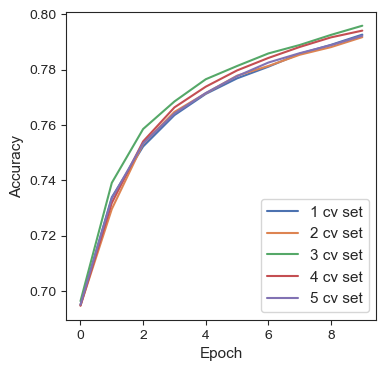

None


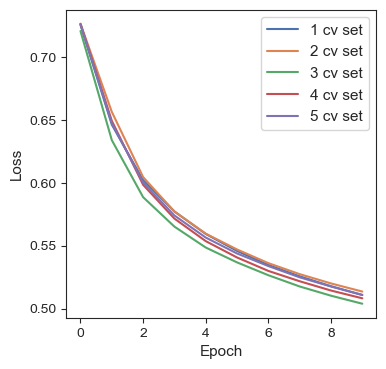

None


In [10]:
accuracy_cv, loss_cv, history_cv, ss_pred_cv, ss_true_cv = simple_model_cross_validation(profile_x_list, seq_x_list, ss_y_list)
mean_accuracy, std_accuracy, mean_loss, std_loss = calculate_mean_std(accuracy_cv, loss_cv)
print(plot_accuracy_epoch(history_cv))
print(plot_loss_epoch(history_cv))

### Optimize window-size in preprocessing step on simple model

- Window size: 7-17 with step 1

*Ref: Optimization of the Sliding Window Size for Protein Structure Prediction: (https://ieeexplore.ieee.org/document/4133195)*

In [133]:
window_size_list = list(range(7, 18, 2))
mean_accuracy_list = []
std_accuracy_list = []
mean_loss_list = []
std_loss_list = []

for window_size in window_size_list:
    print(f'Window size: {window_size}.\n-------------------------------\n-------------------------------')
    profile_x_list, seq_x_list, ss_y_list = create_validation_sets(window_size)
    accuracy_cv, loss_cv, history_cv, ss_pred_cv, ss_true_cv = simple_model_cross_validation(
        profile_x_list, 
        seq_x_list, 
        ss_y_list)
    mean_accuracy, std_accuracy, mean_loss, std_loss = calculate_mean_std(accuracy_cv, loss_cv)
    
    mean_accuracy_list.append(mean_accuracy)
    std_accuracy_list.append(std_accuracy)
    mean_loss_list.append(mean_loss)
    std_loss_list.append(std_loss)

Window size: 7.
-------------------------------
-------------------------------
train1 is preprocessed.
test1 is preprocessed.
train2 is preprocessed.
test2 is preprocessed.
train3 is preprocessed.
test3 is preprocessed.
train4 is preprocessed.
test4 is preprocessed.
train5 is preprocessed.
test5 is preprocessed.
Train/test cross-validation set 1.
-------------------------------
Epoch 1/10
1230/1230 [==============================] - 5s 3ms/step - loss: 0.7721 - accuracy: 0.6710
Epoch 2/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.7019 - accuracy: 0.7081
Epoch 3/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.6739 - accuracy: 0.7214
Epoch 4/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.6593 - accuracy: 0.7282
Epoch 5/10
1016/1230 [=======================>......] - ETA: 0s - loss: 0.6486 - accuracy: 0.7331

KeyboardInterrupt: 

Plot accuracy vs window size. The accuracy increases by increasing the window size. After window size = 13, it seems that it reaches a plateau.

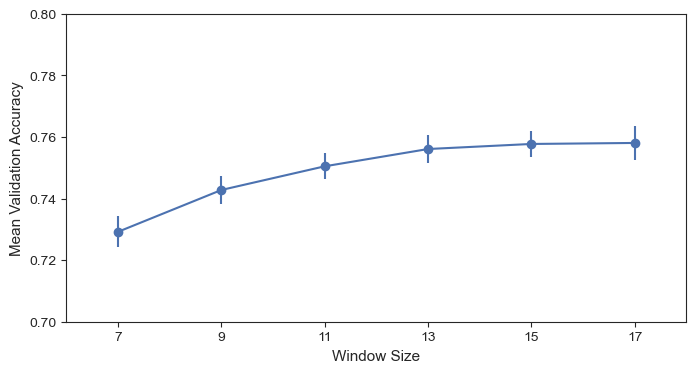

In [12]:
data = {
    'Window Size': window_size_list,
    'Mean Accuracy': mean_accuracy_list,
    'Std Deviation': std_accuracy_list
}
df = pd.DataFrame(data)

sns.set_style('ticks')
palette = sns.color_palette('deep')
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='Window Size', y='Mean Accuracy', errorbar='sd', color=palette[0])
plt.errorbar(df['Window Size'], df['Mean Accuracy'], yerr=df['Std Deviation'], fmt='o', color=palette[0])
plt.xlim(6, 18)
plt.ylim(0.7, 0.8)
plt.xticks(range(7, 18, 2))
plt.xlabel('Window Size', fontname='Arial', fontsize=11)
plt.ylabel('Mean Validation Accuracy', fontname='Arial', fontsize=11)
plt.savefig('windowsize_vs_accuracy.png', dpi=300)
plt.show()

### Model with PSSM input

Optimize this model with trial and error. Try different:
- Number of hidden layers.
- Regularization methods
- Activation functions

In [174]:
def develop_model(profile_x, ss_y, seq_x, profile_x_test, ss_y_test, seq_x_test, accuracy_cv, loss_cv, history_cv, ss_pred_cv):
    """
    Develops a neural network model for secondary structure prediction.

    Args:
        profile_x (numpy.ndarray): Training profile features.
        ss_y (numpy.ndarray): Training secondary structure labels.
        seq_x (numpy.ndarray): Training sequence features.
        profile_x_test (numpy.ndarray): Test profile features.
        ss_y_test (numpy.ndarray): Test secondary structure labels.
        seq_x_test (numpy.ndarray): Test sequence features.
        accuracy_cv (list): List to store accuracy values from cross-validation sets.
        loss_cv (list): List to store loss values from cross-validation sets.
        history_cv (list): List to store Keras History objects from cross-validation sets.
        ss_pred_cv (list): List to store predicted secondary structures from cross-validation sets.

    Returns:
        tuple: A tuple containing updated accuracy_cv, loss_cv, history_cv, and ss_pred_cv lists.

    """
    model = keras.Sequential([
        layers.Input(shape=(profile_x.shape[1])),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.ActivityRegularization(l1=0.06, l2=0.06),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    history = model.fit(profile_x, ss_y, epochs=3, batch_size=128)
    history_cv.append(history)
        
    test_loss, test_accuracy = model.evaluate(profile_x_test, ss_y_test)
    accuracy_cv.append(test_accuracy)
    loss_cv.append(test_loss)
        
    ss_y_pred = model.predict(profile_x_test)
    ss_pred_cv.append(ss_y_pred)
    
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv


def model_cross_validation(profile_x_list, seq_x_list, ss_y_list):
    """
    Performs cross-validation for a neural network model for secondary structure prediction.

    Args:
        profile_x_list (list): A list of lists containing profile features for each cross-validation set.
        seq_x_list (list): A list of lists containing sequence features for each cross-validation set.
        ss_y_list (list): A list of lists containing secondary structure labels for each cross-validation set.

    Returns:
        tuple: A tuple containing accuracy_cv, loss_cv, history_cv, ss_pred_cv, and ss_true_cv lists.

    """
    accuracy_cv = []
    loss_cv = []
    history_cv = []
    ss_pred_cv = []
    ss_true_cv = []
    
    for s in range(len(profile_x_list)):       
        print(f'Train/test cross-validation set {s+1}.\n-------------------------------')
        profile_x = profile_x_list[s][0]
        seq_x = seq_x_list[s][0]
        ss_y = ss_y_list[s][0]
        profile_x_test = profile_x_list[s][1]
        seq_x_test = seq_x_list[s][1]
        ss_y_test = ss_y_list[s][1]
        ss_true_cv.append(ss_y_test)
        
        accuracy_cv, loss_cv, history_cv, ss_pred_cv = develop_model(
            profile_x, 
            ss_y, 
            seq_x, 
            profile_x_test, 
            ss_y_test, 
            seq_x_test, 
            accuracy_cv, 
            loss_cv, 
            history_cv, 
            ss_pred_cv
        )
        
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv, ss_true_cv

Train/test cross-validation set 1.
-------------------------------
Epoch 1/3
1230/1230 [==============================] - 12s 9ms/step - loss: 0.8186 - accuracy: 0.7074
Epoch 2/3
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6339 - accuracy: 0.7805
Epoch 3/3
1273/1273 [==============================] - 2s 2ms/step
Train/test cross-validation set 2.
-------------------------------
Epoch 1/3
1241/1241 [==============================] - 12s 9ms/step - loss: 0.8103 - accuracy: 0.7149
Epoch 2/3
1241/1241 [==============================] - 11s 9ms/step - loss: 0.6375 - accuracy: 0.7790
Epoch 3/3
1229/1229 [==============================] - 3s 2ms/step
Train/test cross-validation set 3.
-------------------------------
Epoch 1/3
1238/1238 [==============================] - 12s 9ms/step - loss: 0.8644 - accuracy: 0.6730
Epoch 2/3
1238/1238 [==============================] - 12s 9ms/step - loss: 0.6393 - accuracy: 0.7810
Epoch 3/3
1241/1241 [==============================] 

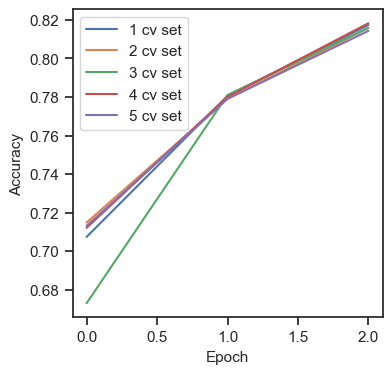

None


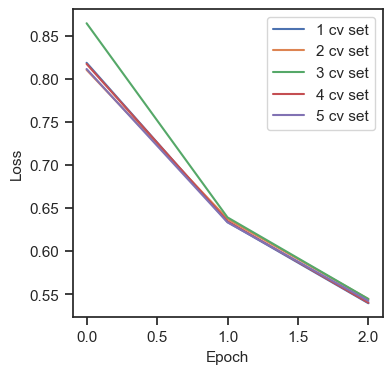

None


In [175]:
accuracy_cv, loss_cv, history_cv, ss_pred_cv, ss_true_cv = model_cross_validation(profile_x_list, seq_x_list, ss_y_list)
mean_accuracy, std_accuracy, mean_loss, std_loss = calculate_mean_std(accuracy_cv, loss_cv)
print(plot_accuracy_epoch(history_cv))
print(plot_loss_epoch(history_cv))

### Ensemble Model

In [9]:
def develop_ensemble_model(
    profile_x, 
    ss_y, 
    seq_x, 
    profile_x_test, 
    ss_y_test, 
    seq_x_test, 
    accuracy_cv, 
    loss_cv, 
    history_cv, 
    ss_pred_cv
):
    """
    Develops an ensemble model for secondary structure prediction.

    Args:
        profile_x (numpy.ndarray): Training profile features.
        ss_y (numpy.ndarray): Training secondary structure labels.
        seq_x (numpy.ndarray): Training sequence features.
        profile_x_test (numpy.ndarray): Test profile features.
        ss_y_test (numpy.ndarray): Test secondary structure labels.
        seq_x_test (numpy.ndarray): Test sequence features.
        accuracy_cv (list): List to store accuracy values from cross-validation sets.
        loss_cv (list): List to store loss values from cross-validation sets.
        history_cv (list): List to store Keras History objects from cross-validation sets.
        ss_pred_cv (list): List to store predicted secondary structures from cross-validation sets.

    Returns:
        tuple: A tuple containing updated accuracy_cv, loss_cv, history_cv, and ss_pred_cv lists.

    """
    inputA = layers.Input(shape=(340))
    inputB = layers.Input(shape=(340))
    
    # First branch operates on the first input
    x = layers.Dense(1024, activation='leaky_relu')(inputA)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = Model(inputs=inputA, outputs=x)
    
    # Second branch operates on the second input
    y = Model(inputs=inputB, outputs=inputB)
    
    combined = layers.concatenate([x.output, y.output])  # combine the output of the two branches
    z = layers.Dense(64, activation="relu")(combined)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(3, activation='softmax')(z)
    model = Model(inputs=[x.input, y.input], outputs=z)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    history = model.fit([profile_x, seq_x], ss_y, epochs=10, batch_size=128)
    history_cv.append(history)
        
    test_loss, test_accuracy = model.evaluate([profile_x_test, seq_x_test], ss_y_test)
    accuracy_cv.append(test_accuracy)
    loss_cv.append(test_loss)
        
    ss_y_pred = model.predict([profile_x_test, seq_x_test])
    ss_pred_cv.append(ss_y_pred)
    
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv


def ensemble_model_cross_validation(profile_x_list, seq_x_list, ss_y_list):
    """
    Performs cross-validation for an ensemble model for secondary structure prediction.

    Args:
        profile_x_list (list): A list of lists containing profile features for each cross-validation set.
        seq_x_list (list): A list of lists containing sequence features for each cross-validation set.
        ss_y_list (list): A list of lists containing secondary structure labels for each cross-validation set.

    Returns:
        tuple: A tuple containing accuracy_cv, loss_cv, history_cv, ss_pred_cv, and ss_true_cv lists.

    """
    accuracy_cv = []
    loss_cv = []
    history_cv = []
    ss_pred_cv = []
    ss_true_cv = []
    
    for s in range(len(profile_x_list)):       
        print(f'Train/test cross-validation set {s+1}.\n-------------------------------')
        profile_x = profile_x_list[s][0]
        seq_x = seq_x_list[s][0]
        ss_y = ss_y_list[s][0]
        profile_x_test = profile_x_list[s][1]
        seq_x_test = seq_x_list[s][1]
        ss_y_test = ss_y_list[s][1]
        ss_true_cv.append(ss_y_test)
        
        accuracy_cv, loss_cv, history_cv, ss_pred_cv = develop_ensemble_model(
            profile_x, 
            ss_y, 
            seq_x, 
            profile_x_test, 
            ss_y_test, 
            seq_x_test, 
            accuracy_cv, 
            loss_cv, 
            history_cv, 
            ss_pred_cv
        )
        
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv, ss_true_cv

Train/test cross-validation set 1.
-------------------------------


Epoch 1/10


1230/1230 [==============================] - 25s 19ms/step - loss: 0.7650 - accuracy: 0.6755
Epoch 2/10
1230/1230 [==============================] - 25s 20ms/step - loss: 0.6539 - accuracy: 0.7341
Epoch 3/10
1230/1230 [==============================] - 24s 19ms/step - loss: 0.6232 - accuracy: 0.7470
Epoch 4/10
1230/1230 [==============================] - 24s 20ms/step - loss: 0.6034 - accuracy: 0.7566
Epoch 5/10
1230/1230 [==============================] - 24s 19ms/step - loss: 0.5909 - accuracy: 0.7615
Epoch 6/10
1230/1230 [==============================] - 25s 21ms/step - loss: 0.5822 - accuracy: 0.7641
Epoch 7/10
1230/1230 [==============================] - 25s 20ms/step - loss: 0.5745 - accuracy: 0.7680
Epoch 8/10
1230/1230 [==============================] - 24s 20ms/step - loss: 0.5673 - accuracy: 0.7724
Epoch 9/10
1230/1230 [==============================] - 26s 21ms/step - loss: 0.5605 - accuracy: 

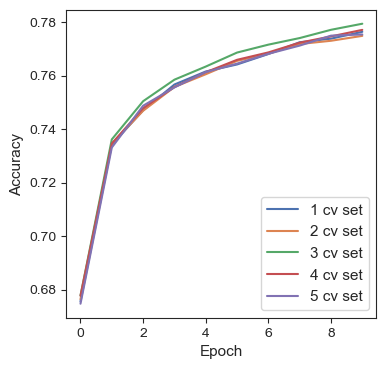

None


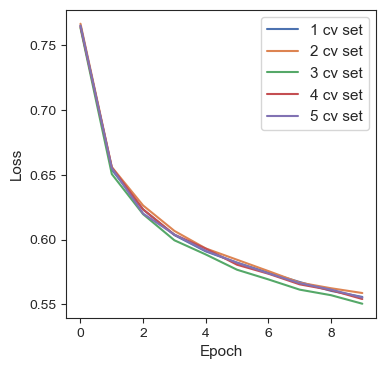

None


In [15]:
accuracy_cv, loss_cv, history_cv, ss_pred_cv, ss_true_cv = ensemble_model_cross_validation(profile_x_list, seq_x_list, ss_y_list)
mean_accuracy, std_accuracy, mean_loss, std_loss = calculate_mean_std(accuracy_cv, loss_cv)
print(plot_accuracy_epoch(history_cv))
print(plot_loss_epoch(history_cv))

### Hyperparameter Optimization with Bayesian Tuner

In [ ]:
def build_model(hp):
    inputA = layers.Input(shape=(340))
    inputB = layers.Input(shape=(340))
    
    # First branch operates on the first input
    x = layers.Dense(
        hp.Int('units_hp_4', min_value=1024, max_value=1536, step=256),
        activation=hp.Choice('act_fun_4', values=['relu','leaky_relu'])
    )(inputA)
    x = layers.Dropout(hp.Float('dropout_4', min_value=0.4, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_hp_3', min_value=512, max_value=1024, step=128), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_3', min_value=0.4, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_hp_2', min_value=256, max_value=512, step=64), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_hp_1', min_value=128, max_value=256, step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1))(x)
    x = Model(inputs=inputA, outputs=x)
    
    # Second branch operates on the second input
    y = Model(inputs=inputB, outputs=inputB)
    
    combined = layers.concatenate([x.output, y.output])  # combine the output of the two branches
    z = layers.Dense(hp.Int('units_hp_0', min_value=32, max_value=128, step=32), activation='relu')(combined)
    z = layers.Dropout(hp.Float('dropout_0', min_value=0.3, max_value=0.5, step=0.1))(z)
    z = layers.Dense(3, activation='softmax')(z)
    model = Model(inputs=[x.input, y.input], outputs=z)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model
    
tuner = BayesianOptimization(build_model, objective = 'val_accuracy', max_trials = 50, overwrite = True)
tuner.search(
    [profile_x_list[0][0], seq_x_list[0][0]], 
    ss_y_list[0][0], 
    epochs = 10, 
    validation_data = ([profile_x_list[0][1], seq_x_list[0][1]], ss_y_list[0][1])
)

### Ablation Study

Visualization of the results of an ablation study conducted on deep learning models. The purpose of this visualization is to show the impact of individual components or changes in a model by systematically adding or altering them (from bottom to top). The study investigates various configurations and their corresponding validation mean accuracies.

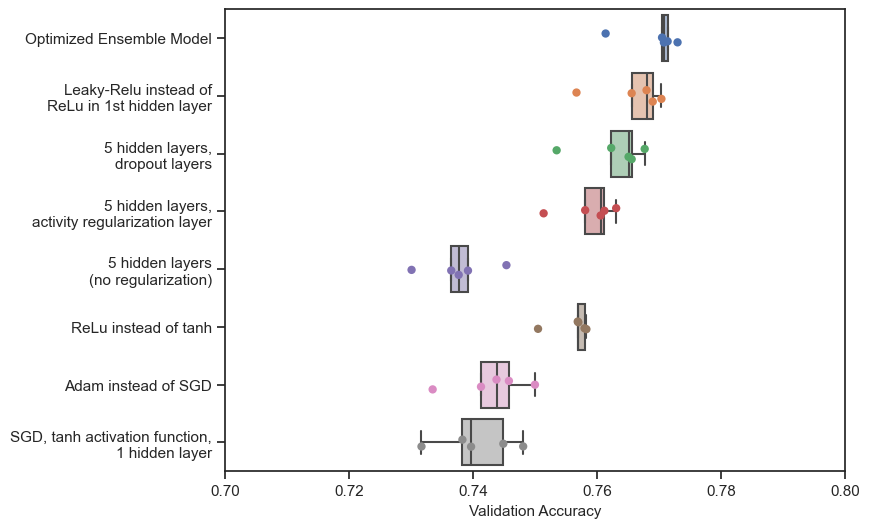

In [30]:
labels = [
    'Optimized Ensemble Model', 
    'Leaky-Relu instead of\nReLu in 1st hidden layer',
    '5 hidden layers,\ndropout layers',
    '5 hidden layers,\nactivity regularization layer',
    '5 hidden layers\n(no regularization)',
    'ReLu instead of tanh',
    'Adam instead of SGD',
    'SGD, tanh activation function,\n1 hidden layer'
]
data = {
    'Label': [label for label in labels for _ in range(5)],
    'Values': [
        0.7705, 0.7730, 0.7614, 0.7714, 0.7708, 
        0.7690, 0.7680, 0.7567, 0.7656, 0.7704, 
        0.7677, 0.7651, 0.7535, 0.7623, 0.7656,
        0.7612, 0.7631, 0.7514, 0.7581, 0.7606,
        0.7377, 0.7365, 0.7301, 0.7392, 0.7454,
        0.7569, 0.7570, 0.7505, 0.7583, 0.7580,
        0.7438, 0.7413, 0.7335, 0.7500, 0.7458,
        0.7383, 0.7397, 0.7317, 0.7481, 0.7449
    ]
}
sens_analysis_data = pd.DataFrame(data)

sns.set(style='ticks')
palette = sns.color_palette('deep')
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Values', y='Label', data=sens_analysis_data, orient="h", showfliers=False)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
sns.stripplot(x='Values', y='Label', hue='Label', data=sens_analysis_data, orient='h', size=6)

plt.xlim(0.7, 0.8)
plt.xlabel('Validation Accuracy', fontname='Arial', fontsize=11)
plt.ylabel('',  fontname='Arial', fontsize=11)
plt.legend([],[], frameon=False)
plt.savefig('ablation_study.png', dpi=300, bbox_inches='tight')
plt.show()

# Final Model Testing

Optimize selected model hyperparameters with the Bayesian optimization method.

Train with cv train sets and test with blind test sets.

In [7]:
def ensemble_model_blind_test(profile_x_list, seq_x_list, ss_y_list, profile_x_blindtest, seq_x_blindtest, ss_y_blindtest):
    accuracy_cv = []
    loss_cv = []
    history_cv = []
    ss_pred_cv = []
    ss_true_cv = []
    
    for s in range(len(profile_x_list)):       
        print(f'Train/test cross-validation set {s+1}.\n-------------------------------')
        profile_x = profile_x_list[s][0]
        seq_x = seq_x_list[s][0]
        ss_y = ss_y_list[s][0]
        profile_x_test = profile_x_blindtest
        seq_x_test = seq_x_blindtest
        ss_y_test = ss_y_blindtest
        ss_true_cv.append(ss_y_test)
        
        accuracy_cv, loss_cv, history_cv, ss_pred_cv = develop_ensemble_model(
            profile_x, 
            ss_y, 
            seq_x, 
            profile_x_test, 
            ss_y_test, 
            seq_x_test, 
            accuracy_cv, 
            loss_cv, 
            history_cv, 
            ss_pred_cv
        )
        
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv, ss_true_cv

Use optimized model on the blind test set.

Train/test cross-validation set 1.
-------------------------------
Epoch 1/10
1230/1230 [==============================] - 22s 17ms/step - loss: 0.7659 - accuracy: 0.6756
Epoch 2/10
1230/1230 [==============================] - 22s 18ms/step - loss: 0.6540 - accuracy: 0.7353
Epoch 3/10
1230/1230 [==============================] - 23s 18ms/step - loss: 0.6232 - accuracy: 0.7489
Epoch 4/10
1230/1230 [==============================] - 22s 18ms/step - loss: 0.6024 - accuracy: 0.7561
Epoch 5/10
1230/1230 [==============================] - 23s 19ms/step - loss: 0.5922 - accuracy: 0.7615
Epoch 6/10
1230/1230 [==============================] - 22s 18ms/step - loss: 0.5829 - accuracy: 0.7652
Epoch 7/10
1230/1230 [==============================] - 23s 19ms/step - loss: 0.5733 - accuracy: 0.7685
Epoch 8/10
1230/1230 [==============================] - 23s 18ms/step - loss: 0.5665 - accuracy: 0.7710
Epoch 9/10
1230/1230 [==============================] - 23s 18ms/step - loss: 0.5589 - accuracy: 0.77

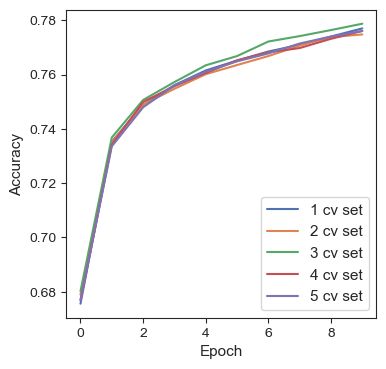

None


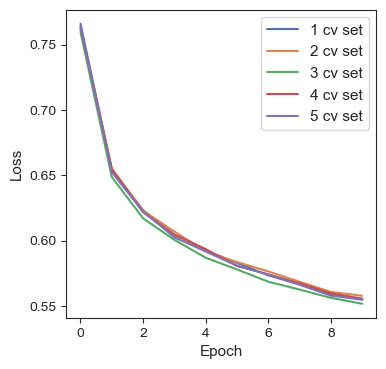

None


In [14]:
accuracy_test, loss_test, history_test, ss_pred_test, ss_true_test = ensemble_model_blind_test(
    profile_x_list, 
    seq_x_list, 
    ss_y_list, 
    profile_x_blindtest, 
    seq_x_blindtest, 
    ss_y_blindtest
)
mean_accuracy, std_accuracy, mean_loss, std_loss = calculate_mean_std(accuracy_test, loss_test)
print(plot_accuracy_epoch(history_test))
print(plot_loss_epoch(history_test))

## Calculate Metrics for Final Model

Classes:
- H-helix
- E-sheet
- C-coil

Calculate confusion matrix, accuracy, sensitivity and specificity for each class using the "one-vs-all" approach.

### Utility function

In [57]:
def make_one_hot(matrix):
    max_indices = np.argmax(matrix, axis=-1)  # Find the index of the maximum value along the last axis
    one_hot_matrix = np.zeros_like(matrix)  # Create a new array with the same shape as the original matrix
    one_hot_matrix[np.arange(len(matrix)), max_indices] = 1  # Set the maximum value to 1
    return one_hot_matrix


def transform_output(sets, decode_dict):
    decoded_sets = []
    
    for cv_set in sets:
        decoded_set = []
        cv_set = make_one_hot(cv_set)
        
        for row in cv_set:
            index = np.argmax(row)
            decoded_value = decode_dict[tuple(row)]
            decoded_set.append(decoded_value)
            
        decoded_set = np.array(decoded_set)
        decoded_sets.append(decoded_set)
        
    return decoded_sets


def create_cm(ss_true_test, ss_pred_test, decode_dict):
    ss_pred = transform_output(ss_pred_test, decode_dict)
    ss_true = transform_output(ss_true_test, decode_dict)
    cm_list = []
    
    for i in range(len(ss_true)):
        cm = confusion_matrix(ss_true[i], ss_pred[i])
        cm_list.append(cm)
        
    return cm_list, ss_true


def calculate_class_metrics(confusion_matrix):
    sensitivity = np.zeros(confusion_matrix.shape[0])
    specificity = np.zeros(confusion_matrix.shape[0])
    accuracy = np.zeros(confusion_matrix.shape[0])
    
    for i in range(confusion_matrix.shape[0]):
        TP = confusion_matrix[i, i]
        FN = confusion_matrix[i, :].sum() - TP
        FP = np.sum(confusion_matrix[:, i]) - TP
        TN = np.sum(confusion_matrix) - TP - FP - FN

        sensitivity[i] = TP / (TP + FN)
        specificity[i] = TN / (TN + FP)
        accuracy[i] = (TP + TN) / (TP + FN + TN + FP)
        
    return sensitivity, specificity, accuracy


def print_mean_std_metrics_table(
    mean_accuracy, 
    std_accuracy, 
    mean_sensitivity, 
    std_sensitivity, 
    mean_specificity, 
    std_specificity
):
    print(f'-----------------------------\nHelix:\n-----------------------------')
    print(f'Mean Accuracy:     {mean_accuracy[0]}')
    print(f'Std Dev Accuracy:  {std_accuracy[0]}')
    print('-----------------------------')
    print(f'Mean Sensitivity:     {mean_sensitivity[0]}')
    print(f'Std Dev Sensitivity:  {std_sensitivity[0]}')
    print('-----------------------------')
    print(f'Mean Specificity:     {mean_specificity[0]}')
    print(f'Std Dev Specificity:  {std_specificity[0]}')
    print(f'-----------------------------\nSheet:\n-----------------------------')
    print(f'Mean Accuracy:     {mean_accuracy[1]}')
    print(f'Std Dev Accuracy:  {std_accuracy[1]}')
    print('-----------------------------')
    print(f'Mean Sensitivity:     {mean_sensitivity[1]}')
    print(f'Std Dev Sensitivity:  {std_sensitivity[1]}')
    print('-----------------------------')
    print(f'Mean Specificity:     {mean_specificity[1]}')
    print(f'Std Dev Specificity:  {std_specificity[1]}')
    print(f'-----------------------------\nCoil:\n-----------------------------')
    print(f'Mean Accuracy:     {mean_accuracy[2]}')
    print(f'Std Dev Accuracy:  {std_accuracy[2]}')
    print('-----------------------------')
    print(f'Mean Sensitivity:     {mean_sensitivity[2]}')
    print(f'Std Dev Sensitivity:  {std_sensitivity[2]}')
    print('-----------------------------')
    print(f'Mean Specificity:     {mean_specificity[2]}')
    print(f'Std Dev Specificity:  {std_specificity[2]}')


def calculate_mean_std_metrics(sensitivity_list, specificity_list, accuracy_list):
    accuracy_array = np.array(accuracy_list)
    sensitivity_array = np.array(sensitivity_list)
    specificity_array = np.array(specificity_list)
    
    mean_accuracy = np.mean(accuracy_array, axis=0)
    std_accuracy = np.std(accuracy_array, axis=0)
    mean_sensitivity = np.mean(sensitivity_array, axis=0)
    std_sensitivity = np.std(sensitivity_array, axis=0)
    mean_specificity = np.mean(specificity_array, axis=0)
    std_specificity = np.std(specificity_array, axis=0)
    
    print_mean_std_metrics_table(
    mean_accuracy, 
    std_accuracy, 
    mean_sensitivity, 
    std_sensitivity, 
    mean_specificity, 
    std_specificity
)
    
    return mean_accuracy, std_accuracy, mean_sensitivity, std_sensitivity, mean_specificity, std_specificity

- Decode the data. Softmax output to one-hot-encoding to class (0, 1, 2).
- Confusion matrix for each validation set.
- Accuracy, sensitivity and specificity calculation for each class and each valdiation set.
- Mean and standard deviation of accuracy, sensitivity and specificity calculation for each class.

In [24]:
decode_dict = {
    (1, 0, 0): 0,
    (0, 1, 0): 1,
    (0, 0, 1): 2
}

cm_list, ss_true = create_cm(ss_true_test, ss_pred_test, decode_dict)

sensitivity_list = []
specificity_list = []
accuracy_list = []

for cm in cm_list:
    sensitivity, specificity, accuracy = calculate_class_metrics(cm)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    accuracy_list.append(accuracy)
    
mean_accuracy, std_accuracy, mean_sensitivity, std_sensitivity, mean_specificity, std_specificity = calculate_mean_std_metrics(
    sensitivity_list, 
    specificity_list, 
    accuracy_list
)

-----------------------------
Helix:
-----------------------------
Mean Accuracy:     0.8511426548216814
Std Dev Accuracy:  0.0013259748967228936
-----------------------------
Mean Sensitivity:     0.741452708298824
Std Dev Sensitivity:  0.01467929955044216
-----------------------------
Mean Specificity:     0.9208697483415816
Std Dev Specificity:  0.008887915170538203
-----------------------------
Sheet:
-----------------------------
Mean Accuracy:     0.8724346594566758
Std Dev Accuracy:  0.0009079260276016023
-----------------------------
Mean Sensitivity:     0.6436036036036036
Std Dev Sensitivity:  0.012066136910812151
-----------------------------
Mean Specificity:     0.9451591694767874
Std Dev Specificity:  0.003814585104733233
-----------------------------
Coil:
-----------------------------
Mean Accuracy:     0.7831305523368096
Std Dev Accuracy:  0.0035253218878091735
-----------------------------
Mean Sensitivity:     0.8373429552667044
Std Dev Sensitivity:  0.01374203174554

### Plot results for each class

Plot confusion matrix for the best set.

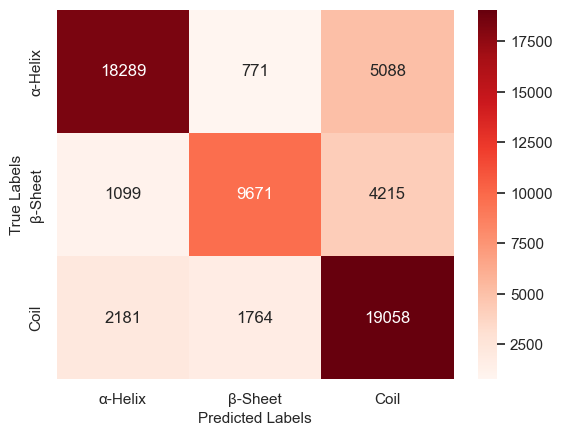

In [40]:
class_labels = ['α-Helix', 'β-Sheet', 'Coil']
sns.set(style='ticks')
palette = sns.color_palette('deep')
sns.set(font_scale = 1)
sns.heatmap(cm_list[3], annot = True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontname='Arial', fontsize=11)
plt.ylabel('True Labels', fontname='Arial', fontsize=11)
plt.title('')
plt.savefig('confmatrix_blindtest.png', dpi=300, bbox_inches='tight')
plt.show()

Plot mean accuracy, sensitivity and specificity for each class.

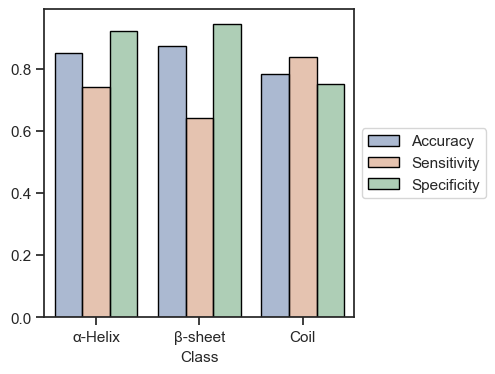

In [29]:
class_labels = ['α-Helix', 'β-sheet', 'Coil']

# Process data to plot
metrics_data = {
    'class': [],
    'metric': [],
    'value': []
}

for label in class_labels:
    metrics_data['class'].extend([label for label in class_labels])
metrics_data['metric'].extend(3*['Accuracy'])
metrics_data['metric'].extend(3*['Sensitivity'])
metrics_data['metric'].extend(3*['Specificity'])
metrics_data['value'].extend(mean_accuracy)
metrics_data['value'].extend(mean_sensitivity)
metrics_data['value'].extend(mean_specificity)

metrics_data = pd.DataFrame(metrics_data)

sns.set(style='ticks')
palette = sns.color_palette('deep')
plt.figure(figsize=(4, 4))
ax = sns.barplot(data=metrics_data, x='class', y='value', hue='metric', edgecolor='black', linewidth=1)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.5))
plt.xlabel('Class', fontname='Arial', fontsize=11)
plt.ylabel('', fontname='Arial', fontsize=11)
font = FontProperties()
font.set_family('Arial')
font.set_size('11')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='', prop=font)
plt.savefig('classmetrics_blindtest.png', dpi=300, bbox_inches='tight')
plt.show()

Plot percentage of individualized classes in blind test set.

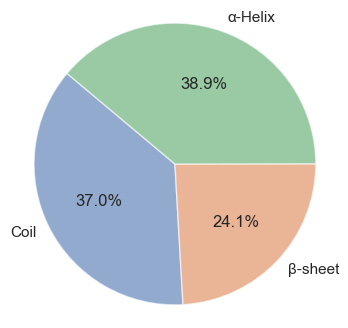

In [126]:
counts = {}

for val in ss_true_test[0]:
    arr_tuple = tuple(val)
    counts[arr_tuple] = counts.get(arr_tuple, 0) + 1

class_labels = ['Coil', 'β-sheet', 'α-Helix']

sns.set(style='ticks')
palette = sns.color_palette('deep')
plt.figure(figsize=(4, 4))
plt.pie(counts.values(), labels=class_labels, autopct='%1.1f%%', startangle=140, wedgeprops={'alpha':0.6})
plt.axis('equal')
plt.show()

# User Interface

In [82]:
def create_user_profiles(profile, seq, window_size):
    ss_map = {'H': 0, 'E': 1, 'C': 2, '-': 2}
    profile_x = []
    seq_x = []
    for i in range(0, len(profile)):
        half_window_size = int((window_size-1)/2)
        # Apply the sliding window method to PSSM profiles
        part1 = np.zeros(20*max(0, half_window_size-i))
        part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
        part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
        vec = np.concatenate((part1, part2, part3))
        profile_x.append(vec.tolist())
                    
        one_hot_seq = sequence_to_one_hot(seq)
        # Apply the sliding window method to one-hot-encoded sequences
        part1 = np.zeros(20*max(0, half_window_size-i))
        part2 = np.ndarray.flatten(one_hot_seq[max(0,i-half_window_size):min(i+half_window_size+1,len(one_hot_seq))])
        part3 = np.zeros(20*max(0, half_window_size-(len(one_hot_seq)-i-1)))
        vec = np.concatenate((part1, part2, part3))
        seq_x.append(vec.tolist())
                    
    return profile_x, seq_x


def preprocess_user_data(file_path, window_size = 17, str_transformation = True):  
    profile = np.array(parse_pssm(file_path))
            
    if np.sum(profile) != 0:
        seq = extract_sequence_from_pssm(file_path)
        profile_x, seq_x = create_user_profiles(profile, seq, window_size)
        profile_x = np.array(profile_x)
        seq_x = np.array(seq_x)
        
    return profile_x, seq_x


def create_user_validation_sets(window_size):
    """
    Creates validation sets for cross-validation.

    Args:
        window_size (int): The window size for creating profiles.

    Returns:
        tuple: A tuple containing lists of profile features, sequence features, and secondary structure labels for each 
        validation set.

    """
    names_list = [
        ['train4', 'test4']
    ]

    profile_x_list = []
    seq_x_list = []
    ss_y_list = []

    for train_name, test_name in names_list:
        profile_x_sublist = []
        seq_x_sublist = []
        ss_y_sublist = []

        train_path = 'protein-ss-pred-master/data/training/cv/' + train_name + '.txt'
        test_path = 'protein-ss-pred-master/data/training/cv/' + test_name + '.txt'
        print(f'{train_name} is preprocessed.')

        profile_x, seq_x, ss_y  = preprocess_data(train_path,
                                                  'protein-ss-pred-master/data/training/',
                                                  window_size = window_size,
                                                  str_transformation = True
                                                 )
        profile_x_sublist.append(profile_x)
        seq_x_sublist.append(seq_x)
        ss_y_sublist.append(ss_y)

        print(f'{test_name} is preprocessed.')

        profile_x_test, seq_x_test, ss_y_test  = preprocess_data(test_path,
                                                                 'protein-ss-pred-master/data/training/',
                                                                 window_size = window_size,
                                                                 str_transformation = True
                                                                )
        profile_x_sublist.append(profile_x_test)
        seq_x_sublist.append(seq_x_test)
        ss_y_sublist.append(ss_y_test)

        profile_x_list.append(profile_x_sublist)
        seq_x_list.append(seq_x_sublist)
        ss_y_list.append(ss_y_sublist)
        
    return profile_x_list, seq_x_list, ss_y_list


def develop_user_ensemble_model(
    profile_x, 
    ss_y, 
    seq_x, 
    profile_x_test, 
    seq_x_test, 
    accuracy_cv, 
    loss_cv, 
    history_cv, 
    ss_pred_cv
):
    inputA = layers.Input(shape=(340))
    inputB = layers.Input(shape=(340))
    
    # First branch operates on the first input
    x = layers.Dense(1024, activation='leaky_relu')(inputA)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = Model(inputs=inputA, outputs=x)
    
    # Second branch operates on the second input
    y = Model(inputs=inputB, outputs=inputB)
    
    combined = layers.concatenate([x.output, y.output])  # combine the output of the two branches
    z = layers.Dense(64, activation="relu")(combined)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(3, activation='softmax')(z)
    model = Model(inputs=[x.input, y.input], outputs=z)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    history = model.fit([profile_x, seq_x], ss_y, epochs=10, batch_size=128)
    history_cv.append(history)
        
    ss_y_pred = model.predict([profile_x_test, seq_x_test])
    ss_pred_cv.append(ss_y_pred)
    
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv


def ensemble_model_user(profile_x_list, seq_x_list, ss_y_list, profile_x_blindtest, seq_x_blindtest):
    accuracy_cv = []
    loss_cv = []
    history_cv = []
    ss_pred_cv = []
    
    for s in range(len(profile_x_list)):       
        print(f'Train/test cross-validation set {s+1}.\n-------------------------------')
        profile_x = profile_x_list[s][0]
        seq_x = seq_x_list[s][0]
        ss_y = ss_y_list[s][0]
        profile_x_test = profile_x_blindtest
        seq_x_test = seq_x_blindtest
        
        accuracy_cv, loss_cv, history_cv, ss_pred_cv = develop_user_ensemble_model(
            profile_x, 
            ss_y, 
            seq_x, 
            profile_x_test,
            seq_x_test, 
            accuracy_cv, 
            loss_cv, 
            history_cv, 
            ss_pred_cv
        )
        
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv


def convert(ss_pred_test):
    probs_array = ss_pred_test[0]
    sequence = ''
    probabilities = []
    
    for prob in probs_array:
        max_prob_index = np.argmax(prob)
        probabilities.append(prob[max_prob_index])
        
        if max_prob_index == 0:
            sequence += 'H'
        elif max_prob_index == 1:
            sequence += 'E'
        else:
            sequence += 'C'
    
    return sequence, probabilities

In [55]:
user_input = input('Provide a file path for a PSSM file: ')
window_size = int(input('Provide a window size (7-17): '))

profile_x_list, seq_x_list, ss_y_list = create_user_validation_sets(window_size = window_size)
profile_x_blindtest, seq_x_blindtest = preprocess_user_data(
    user_input,
    window_size = 17,
    str_transformation = True
)

accuracy_test, loss_test, history_test, ss_pred_test = ensemble_model_user(
    profile_x_list, 
    seq_x_list, 
    ss_y_list, 
    profile_x_blindtest, 
    seq_x_blindtest, 
)

Provide a file path for a PSSM file:  protein-ss-pred-master/data/blindTest/pssm/4S1H_A.pssm
Provide a window size (7-17):  17


train4 is preprocessed.
test4 is preprocessed.
Train/test cross-validation set 1.
-------------------------------
Epoch 1/10
1245/1245 [==============================] - 17s 12ms/step - loss: 0.7631 - accuracy: 0.6778
Epoch 2/10
1245/1245 [==============================] - 16s 13ms/step - loss: 0.6530 - accuracy: 0.7355
Epoch 3/10
1245/1245 [==============================] - 16s 12ms/step - loss: 0.6229 - accuracy: 0.7473
Epoch 4/10
1245/1245 [==============================] - 15s 12ms/step - loss: 0.6047 - accuracy: 0.7558
Epoch 5/10
1245/1245 [==============================] - 15s 12ms/step - loss: 0.5907 - accuracy: 0.7622
Epoch 6/10
1245/1245 [==============================] - 15s 12ms/step - loss: 0.5813 - accuracy: 0.7653
Epoch 7/10
1245/1245 [==============================] - 15s 12ms/step - loss: 0.5750 - accuracy: 0.7687
Epoch 8/10
1245/1245 [==============================] - 16s 13ms/step - loss: 0.5668 - accuracy: 0.7708
Epoch 9/10
1245/1245 [==============================] 

In [56]:
ss_pred_test

[array([[1.28292032e-02, 6.05242141e-02, 9.26646590e-01],
        [1.47173136e-01, 7.57297501e-02, 7.77097046e-01],
        [2.75085211e-01, 1.17082320e-01, 6.07832491e-01],
        [3.70057598e-02, 4.15884495e-01, 5.47109783e-01],
        [2.99289059e-02, 8.12709570e-01, 1.57361507e-01],
        [1.27364816e-02, 8.58800530e-01, 1.28463015e-01],
        [9.94037371e-04, 9.80054379e-01, 1.89516228e-02],
        [3.76629345e-02, 9.11646843e-01, 5.06901443e-02],
        [2.26345006e-02, 8.52344751e-01, 1.25020772e-01],
        [2.69160997e-02, 5.20349383e-01, 4.52734530e-01],
        [5.24183214e-02, 4.64955181e-01, 4.82626528e-01],
        [7.55037814e-02, 3.67207140e-01, 5.57289124e-01],
        [8.75611380e-02, 3.11899662e-01, 6.00539207e-01],
        [1.56879485e-01, 2.81199813e-01, 5.61920762e-01],
        [1.27629369e-01, 2.64329225e-01, 6.08041406e-01],
        [1.59621999e-01, 2.90743172e-01, 5.49634874e-01],
        [1.06446259e-01, 3.84105265e-01, 5.09448469e-01],
        [6.375

In [80]:
sequence, probabilities = convert(ss_pred_test)

In [81]:
sequence

'CCCCEEEEEECCCCCCCCCCHCCEHECHCCCEEEEEEEEEEECCCCCEEECCCCCCHHHHHHHHHHHHHCCCCCCHEEEEECCCCCHHHHHHHHHHHHHHHCCCCCEEEECCCCCCCCCEECCCHHHHHHHHHCCCCCECCCCHHHHHHHCCCCCCCHHHHHHHHHHHHHCCCCEEEEEECCCCCCEEEECCCCCCCCCCCCCECCCCEECCCCCCHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHCCHCCCCCCHHHHHHHHHHCCCC'

In [78]:
probabilities

[0.9266466,
 0.77709705,
 0.6078325,
 0.5471098,
 0.81270957,
 0.85880053,
 0.9800544,
 0.91164684,
 0.85234475,
 0.5203494,
 0.48262653,
 0.5572891,
 0.6005392,
 0.56192076,
 0.6080414,
 0.5496349,
 0.50944847,
 0.7420572,
 0.63858664,
 0.54517317,
 0.60502785,
 0.57276255,
 0.5251928,
 0.44982475,
 0.55565053,
 0.34991464,
 0.43083978,
 0.6561821,
 0.50780874,
 0.8838105,
 0.7310614,
 0.4898744,
 0.59990674,
 0.5962258,
 0.8668036,
 0.83861494,
 0.657447,
 0.79345894,
 0.96009904,
 0.9311757,
 0.6860503,
 0.59075314,
 0.8471065,
 0.8809602,
 0.80400527,
 0.6313512,
 0.6424402,
 0.59089065,
 0.53692085,
 0.64694405,
 0.6625514,
 0.7115298,
 0.54637396,
 0.5211243,
 0.5943812,
 0.77304643,
 0.54951656,
 0.6400999,
 0.7116676,
 0.9484836,
 0.9902908,
 0.9775524,
 0.98965806,
 0.9851028,
 0.85030323,
 0.909361,
 0.9069584,
 0.81053454,
 0.6990996,
 0.5714345,
 0.58006144,
 0.6440582,
 0.8278777,
 0.76803696,
 0.86376506,
 0.52714723,
 0.40928692,
 0.84656924,
 0.8568373,
 0.9091192,
 0.4